In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
from tldextract import extract
import re
from urllib.parse import urlparse
from tld import get_tld
from sklearn.feature_extraction.text import TfidfVectorizer
from googlesearch import search

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

from joblib import dump, load

from sklearn import metrics

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-04-29 11:39:09.836289: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Explore the Dataset
The dataset was taken from: https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset

The dataset contains two features: a URL and a label for that URL. 

The malicious labels can cateogorized as types such as phishing, benign, defacement, or malware. 
1. <b>Phishing</b>: fake websites that deceive victim's into revealing sensitive information  
3. <b>Defacement</b>: legitimate URLs, however, the original website has been replaced with a malicious version of the real website 
4. <b>Malware</b>: URLs that download malicious code onto a victim's computer


In [2]:
df = pd.read_csv('malicious_urls.csv')
df

,url,type
0,br-icloud.com.br,malicious
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,malicious
4,http://adventure-nicaragua.net/index.php?optio...,malicious
...,...,...
1101362,http://ecct-it.com/docmmmnn/aptgd/index.php,malicious
1101363,http://faboleena.com/js/infortis/jquery/plugin...,malicious
1101364,http://faboleena.com/js/infortis/jquery/plugin...,malicious
1101365,http://atualizapj.com/,malicious


In [3]:
df['type'].value_counts()

type
benign       773841
malicious    327526
Name: count, dtype: int64

# Feature Extraction
For each url taken from the dataset I will break it down into the following features to use when training the ML model: 
1. URL Length
2. Primary Domain Length
3. Top Level Domain Length 
4. HTTPS or HTTP
5. Number of HTTP/HTTPs Present 
6. IP Address Present in URL
7. Letter Count
8. Digit Count
9. Ratio of Characters
10. Ratio of Digits 
11. Count of each Special Symbol Count (!,@,#,$,%...)
12. Ration of speical characters 
13. Abnormal URL Structure containing hostname in the URL
14. Malicious Code Present in URL
15. Google Index
16. Uses Shortening Service

I based my code for the IP identification, shortening service use, and code presence on the methods created in the following article: https://www.scribd.com/document/555988515/Malicious-Site-Detection-MSD 

![text](https://media.geeksforgeeks.org/wp-content/uploads/20210625160610/urldiag.PNG)

In [4]:
def get_url_length(url):
  return len(url)

def get_domain_length(url):
  parsed_url = extract(url)
  return len(parsed_url.domain + '.' + parsed_url.suffix)

def get_tld_length(url):
  return len(extract(url).suffix)

In [5]:
df['url_length'] = df['url'].apply(get_url_length)
df['p_domain_length'] = df['url'].apply(get_domain_length)
df['tld_length'] = df['url'].apply(get_tld_length)

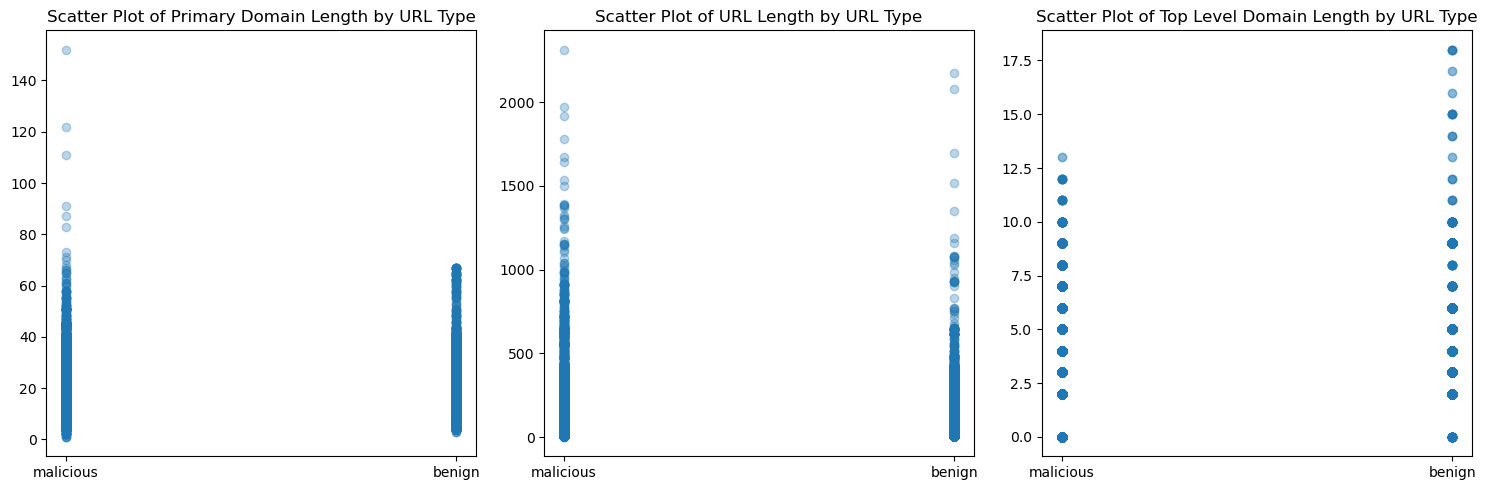

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed

# Plot scatter plots in each subplot
axs[0].scatter(df['type'], df['p_domain_length'], alpha=0.3)
axs[0].set_title('Scatter Plot of Primary Domain Length by URL Type')

axs[1].scatter(df['type'], df['url_length'], alpha=0.3)
axs[1].set_title('Scatter Plot of URL Length by URL Type')

axs[2].scatter(df['type'], df['tld_length'], alpha=0.3)
axs[2].set_title('Scatter Plot of Top Level Domain Length by URL Type')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [9]:
def abnormal_url(url):
  parsed_url = urlparse(url)
  hostname = str(parsed_url.hostname)
  if hostname in parsed_url.path or hostname in parsed_url.query:
    return 1
  return 0
    
df['abnormal_url'] = df['url'].apply(abnormal_url)

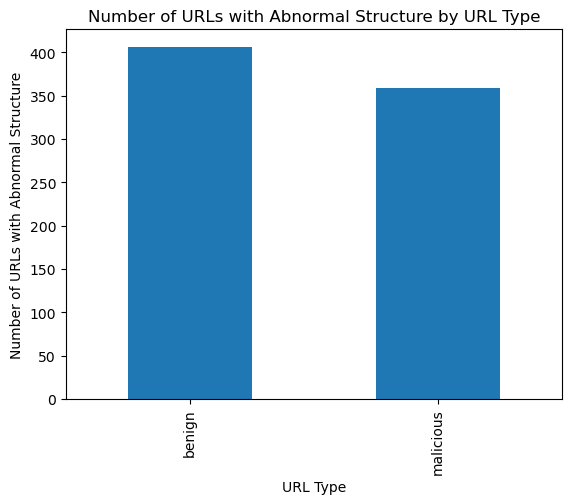

In [10]:
abnormal_counts = df.groupby('type')['abnormal_url'].sum()
abnormal_counts.plot(kind='bar')
plt.xlabel('URL Type')
plt.ylabel('Number of URLs with Abnormal Structure')
plt.title('Number of URLs with Abnormal Structure by URL Type')
plt.show()

In [11]:
def count_http_protocol(url):
  return url.count('http')

def count_https_protocol(url):
  return url.count('https')

def https_found(url):
    if url[:5] == 'https':
        return 1
    else: 
        return 0

In [12]:
df['count_http'] = df['url'].apply(count_http_protocol)
df['count_https'] = df['url'].apply(count_https_protocol)
df['https'] = df['url'].apply(https_found)

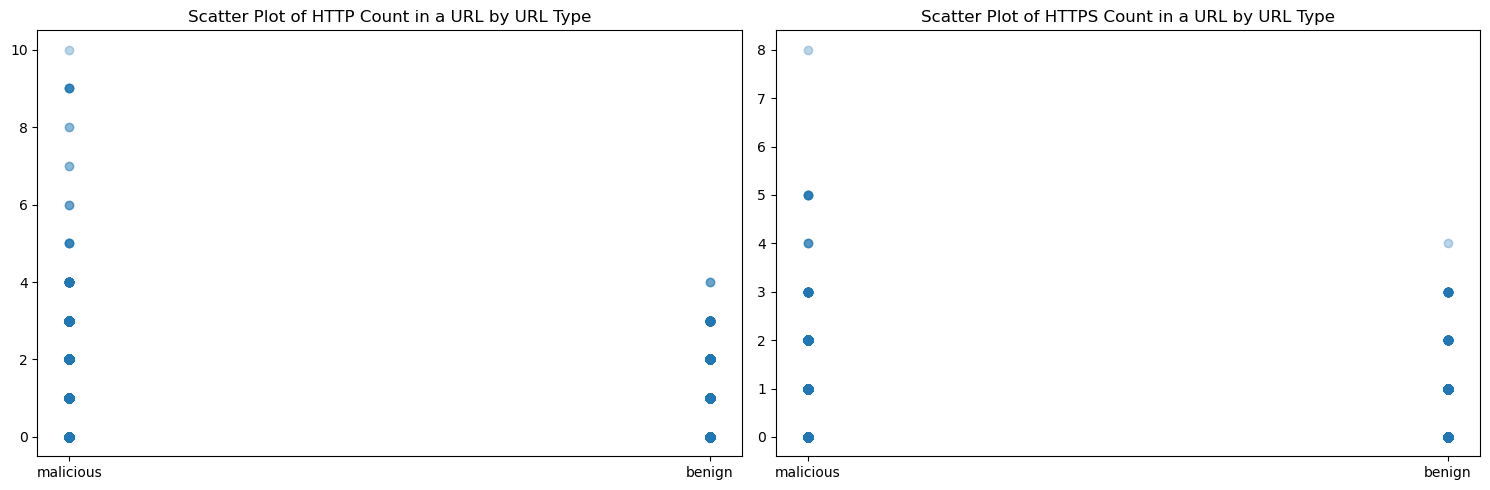

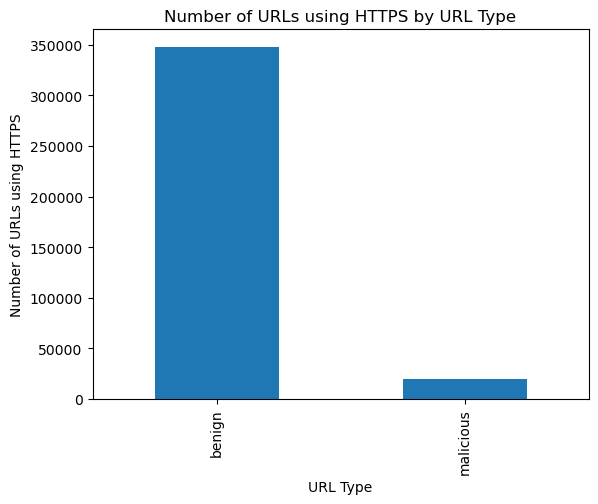

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Adjust figsize as needed

# Plot scatter plots in each subplot
axs[0].scatter(df['type'], df['count_http'], alpha=0.3)
axs[0].set_title('Scatter Plot of HTTP Count in a URL by URL Type')

axs[1].scatter(df['type'], df['count_https'], alpha=0.3)
axs[1].set_title('Scatter Plot of HTTPS Count in a URL by URL Type')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

https_counts = df.groupby('type')['https'].sum()
https_counts.plot(kind='bar')
plt.xlabel('URL Type')
plt.ylabel('Number of URLs using HTTPS')
plt.title('Number of URLs using HTTPS by URL Type')
plt.show()

In [14]:
special_characters = ['@', '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',', '//']
def special_char(url, char):
    return url.count(char)
    
for character in special_characters:
      df['url_count_'+character] = df['url'].apply(lambda url: url.count(character))

In [15]:
def calculate_special_chars_ratio(url):
    num_special_chars = sum(c in special_characters for c in url)
    if len(url) > 0:
        return num_special_chars / len(url) 
    else:
        return 0
    
df['special_chars_ratio'] = df['url'].apply(calculate_special_chars_ratio)

In [16]:
def digit_count(url):
    return sum(1 for c in url if c.isdigit())

def char_count(url):
    return sum(1 for c in url if c.isalpha())

df['digit_count'] = df['url'].apply(digit_count)
df['char_count'] = df['url'].apply(char_count)

In [17]:
def calculate_digit_ratio(url):
    num_digits = sum(1 for c in url if c.isdigit())
    if len(url) > 0:
        return num_digits / len(url) 
    else:
        return 0
    
df['digit_ratio'] = df['url'].apply(calculate_digit_ratio)

def calculate_char_ratio(url):
    num_char = sum(1 for c in url if c.isalpha())
    if len(url) > 0:
        return num_char / len(url) 
    else:
        return 0
    
df['char_ratio'] = df['url'].apply(calculate_char_ratio)

In [18]:
def check_for_code(url):
    if re.search(r'javascript:', url) or re.search(r'<\s*script', url, re.IGNORECASE) or re.search(r'on\w*=', url, re.IGNORECASE):
        return 1
    return 0
    
df['js_code'] = df['url'].apply(check_for_code)

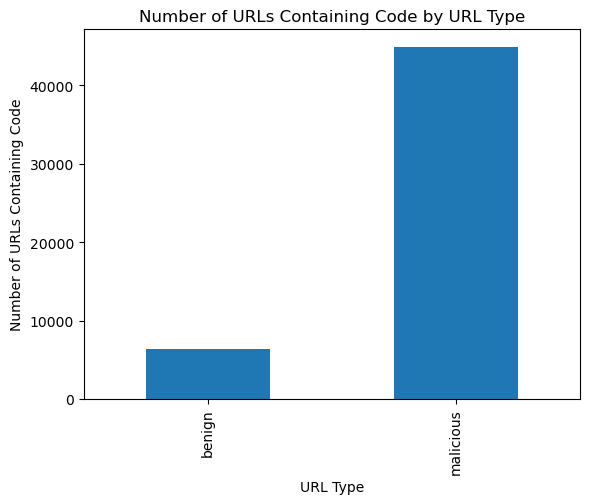

In [19]:
code_counts = df.groupby('type')['js_code'].sum()
code_counts.plot(kind='bar')
plt.xlabel('URL Type')
plt.ylabel('Number of URLs Containing Code')
plt.title('Number of URLs Containing Code by URL Type')
plt.show()

In [20]:
def is_ip_address(url):
    ip_pattern = (
        r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.'
        r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|'
        r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.'
        r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|'
        r'((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\/)'
        r'(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        r'([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        r'((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)'
    )  
    return int(re.search(ip_pattern, url, flags=re.I) is not None)
    
df['ip_addr'] = df['url'].apply(is_ip_address)

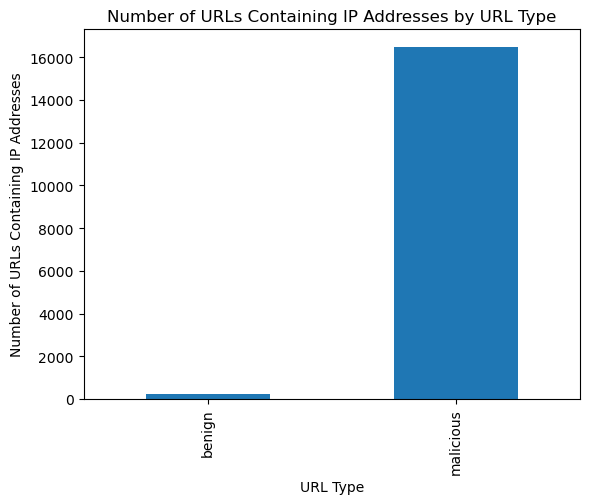

In [21]:
ip_counts = df.groupby('type')['ip_addr'].sum()
ip_counts.plot(kind='bar')
plt.xlabel('URL Type')
plt.ylabel('Number of URLs Containing IP Addresses')
plt.title('Number of URLs Containing IP Addresses by URL Type')
plt.show()

In [22]:
def has_shortening_service(url):
    shortening_pattern = r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|' \
                         r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|' \
                         r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|' \
                         r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|' \
                         r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|' \
                         r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|' \
                         r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|' \
                         r'tr\.im|link\.zip\.net'
    return int(re.search(shortening_pattern, url, flags=re.I) is not None)
    
df['has_shortening_service'] = df['url'].apply(has_shortening_service)

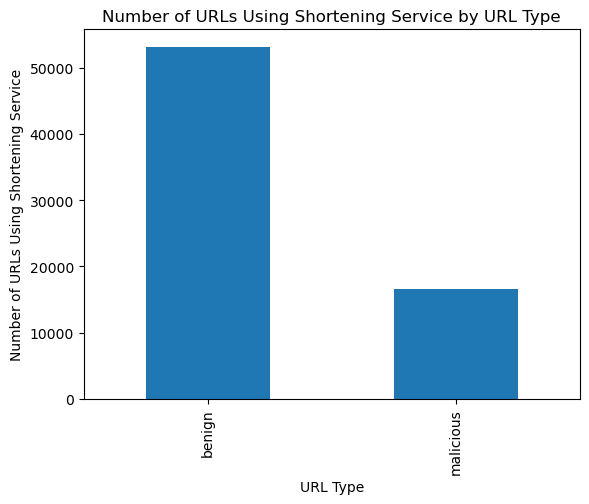

In [23]:
ip_counts = df.groupby('type')['has_shortening_service'].sum()
ip_counts.plot(kind='bar')
plt.xlabel('URL Type')
plt.ylabel('Number of URLs Using Shortening Service')
plt.title('Number of URLs Using Shortening Service by URL Type')
plt.show()

In [24]:
def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
    
df['google_index'] = df['url'].apply(google_index)

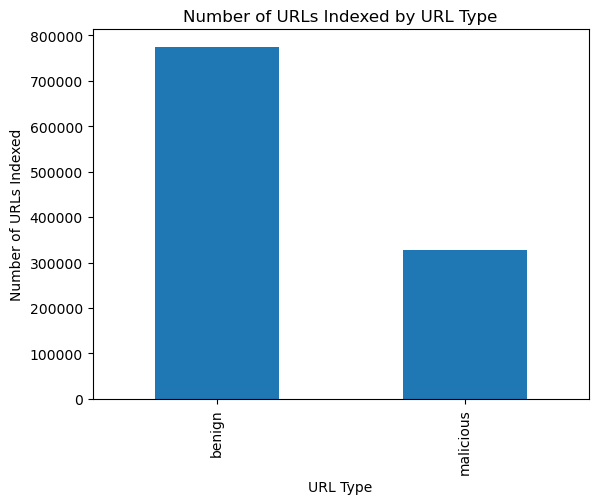

In [25]:
ip_counts = df.groupby('type')['google_index'].sum()
ip_counts.plot(kind='bar')
plt.xlabel('URL Type')
plt.ylabel('Number of URLs Indexed')
plt.title('Number of URLs Indexed by URL Type')
plt.show()

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101367 entries, 0 to 1101366
Data columns (total 31 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   url                     1101367 non-null  object 
 1   type                    1101367 non-null  object 
 2   url_length              1101367 non-null  int64  
 3   p_domain_length         1101367 non-null  int64  
 4   tld_length              1101367 non-null  int64  
 5   abnormal_url            1101367 non-null  int64  
 6   count_http              1101367 non-null  int64  
 7   count_https             1101367 non-null  int64  
 8   https                   1101367 non-null  int64  
 9   url_count_@             1101367 non-null  int64  
 10  url_count_?             1101367 non-null  int64  
 11  url_count_-             1101367 non-null  int64  
 12  url_count_=             1101367 non-null  int64  
 13  url_count_.             1101367 non-null  int64  
 14  ur

## Data Processing

In [27]:
df['type'] = df['type'].map({'benign': 0, 'malicious': 1})

In [28]:
X_train, X_test = train_test_split(df,test_size=.2,stratify=df["type"], random_state=42)

In [29]:
y_train = X_train['type'].copy()
X_train.drop('type', axis=1, inplace=True)

y_test = X_test['type'].copy()
X_test.drop('type', axis=1, inplace=True)

url_train = X_train['url'].copy()
X_train.drop('url', axis=1, inplace=True)

url_test = X_test['url'].copy()
X_test.drop('url', axis=1, inplace=True)

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Choosing a Model 

## Logisitc Regression

In [31]:
lr_model = LogisticRegression(max_iter =1000)
lr_model.fit(X_train_scaled, y_train)
print("Accuracy on training set:", lr_model.score(X_train_scaled, y_train))
print("Accuracy on training set:", lr_model.score(X_test_scaled, y_test))

Accuracy on training set: 0.9014530815702769
Accuracy on training set: 0.9017904972897391


## Decision Tree 

In [32]:
d_clf = DecisionTreeClassifier(random_state=42, criterion="entropy")
d_clf.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [33]:
print("Decision Tree:")
print(" score training data:", d_clf.score(X_train_scaled, y_train))
print(" score test data:", d_clf.score(X_test_scaled, y_test))

y_pred_train = d_clf.predict(X_train_scaled)
y_pred_test = d_clf.predict(X_test_scaled)   

print(" precision training data: ", precision_score(y_train,y_pred_train,average='binary'))
print(" precision test data: ", precision_score(y_test,y_pred_test,average='binary'))

print(" recall training data: ", recall_score(y_train,y_pred_train,average='binary'))
print(" recall test data: ", recall_score(y_test,y_pred_test,average='binary'))

Decision Tree:
 score training data: 0.9843739537143071
 score test data: 0.9598772437963627
 precision training data:  0.9842165831204042
 precision test data:  0.9421513397106787
 recall training data:  0.9628961037474095
 recall test data:  0.921670101518968


### Random Forest

In [34]:
rf = RandomForestClassifier(max_depth=50, n_estimators=75,  min_samples_leaf = 2,
                                   random_state = 42)
rf.fit(X_train_scaled,y_train) 

RandomForestClassifier(max_depth=50, min_samples_leaf=2, n_estimators=75,
                       random_state=42)

In [35]:
print("score training data", rf.score(X_train_scaled, y_train))
print("score test data", rf.score(X_test_scaled, y_test))

y_pred_train = rf.predict(X_train_scaled)
y_pred_test = rf.predict(X_test_scaled)   

print(" precision training data: ", precision_score(y_train,y_pred_train,average='binary'))
print(" precision test data: ", precision_score(y_test,y_pred_test,average='binary'))

print(" recall training data: ", recall_score(y_train,y_pred_train,average='binary'))
print(" recall test data: ", recall_score(y_test,y_pred_test,average='binary'))

score training data 0.9751978508511587
score test data 0.9658607007635944
 precision training data:  0.9797372878647448
 precision test data:  0.9688535989779582
 recall training data:  0.935955515015972
 recall test data:  0.914601938783299


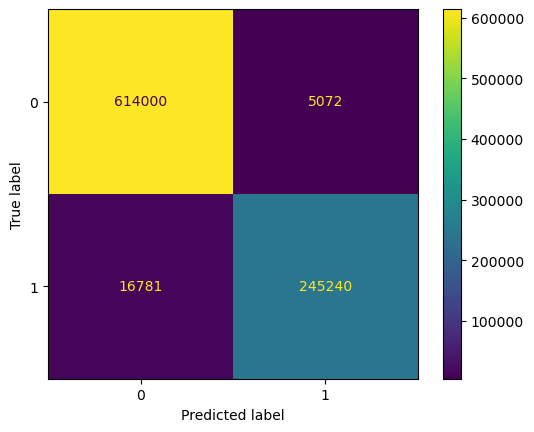

In [36]:
confusion_matrix = metrics.confusion_matrix(y_train, y_pred_train)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

#### Finding the Best Parameters

In [473]:
# min_samples_leaf_list = [2,10, 30, 50, 100, 200, 300]  
# max_depth_list = [2, 8, 16, 32]
# n_estimators_list = [10,50,100]

# parameters = {'max_depth':max_depth_list, 'min_samples_leaf':min_samples_leaf_list, 'n_estimators': n_estimators_list}
# # next create a GridSearchCV object giving it the model and the dictionary of parameters to try
# clf = GridSearchCV(RandomForestClassifier(), parameters)
# clf.fit(X_train_scaled, y_train)
# sorted(clf.cv_results_.keys())
# # show the best parameters
# clf.best_params_

## AdaBoost 

In [37]:
ab_clf = AdaBoostClassifier(learning_rate=1, n_estimators=10,random_state = 42)
ab_clf.fit(X_train, y_train)
print("\nAda Boost:")
print("score training data:", ab_clf.score(X_train, y_train))
print("score test data:", ab_clf.score(X_test, y_test))

y_pred_train = ab_clf.predict(X_train)
y_pred_test = ab_clf.predict(X_test)   

precision_train = precision_score(y_train,y_pred_train,average='binary')
precision_test = precision_score(y_test,y_pred_test,average='binary')

recall_train = recall_score(y_train,y_pred_train,average='binary')
recall_test = recall_score(y_test,y_pred_test,average='binary')

print('Precision Score on training:',precision_train)
print('Precision Score on test:',precision_test)

print('Recall Score on train:',recall_train)
print('Recall Score on test:',recall_test)


Ada Boost:
score training data: 0.899623535767507
score test data: 0.899792985100375
Precision Score on training: 0.909174484937061
Precision Score on test: 0.907246268096917
Recall Score on train: 0.7359906267054931
Recall Score on test: 0.7385390428211587


## Neural Network

In [732]:
model = Sequential([
        Dense(300, activation='relu'),
        Dense(150, activation='relu'),
        Dense(50, activation='relu'),
        Dense(25, activation='relu'),
        Dense(4, activation='softmax')
    ])


In [733]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.001))

model.fit(X_train, y_train, epochs = 15)

Epoch 1/15
27535/27535 [==============================] - 28s 984us/step - loss: 0.1923
Epoch 2/15
27535/27535 [==============================] - 30s 1ms/step - loss: 0.1434
Epoch 3/15
27535/27535 [==============================] - 30s 1ms/step - loss: 0.1292
Epoch 4/15
27535/27535 [==============================] - 29s 1ms/step - loss: 0.1209
Epoch 5/15
27535/27535 [==============================] - 29s 1ms/step - loss: 0.1206
Epoch 6/15
27535/27535 [==============================] - 28s 1ms/step - loss: 0.1167
Epoch 7/15
27535/27535 [==============================] - 27s 990us/step - loss: 0.1145
Epoch 8/15
27535/27535 [==============================] - 30s 1ms/step - loss: 0.1156
Epoch 9/15
27535/27535 [==============================] - 28s 1ms/step - loss: 0.1123
Epoch 10/15
27535/27535 [==============================] - 29s 1ms/step - loss: 0.1123
Epoch 11/15
27535/27535 [==============================] - 28s 999us/step - loss: 0.1103
Epoch 12/15
27535/27535 [=====================

In [747]:
y_pred_train = np.argmax(model.predict(X_train), axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1)
precision_train = precision_score(y_train,y_pred_train,average='binary')
precision_test = precision_score(y_test,y_pred_test,average='binary')

recall_train = recall_score(y_train,y_pred_train,average='binary')
recall_test = recall_score(y_test,y_pred_test,average='binary')

print('Precision Score on training:',precision_train)
print('Precision Score on test:',precision_test)

print('Recall Score on train:',recall_train)
print('Recall Score on test:',recall_test)

6884/6884 [==============================] - 4s 632us/step
Precision Score on training: 0.9664772191785874
Precision Score on test: 0.9659941985283272
Recall Score on train: 0.9001644906324302
Recall Score on test: 0.8998397068926036


# Analyzing the Model

Based on the results, I choose to select the Random Forest Classifier. This is because it had the highest precision score for the test set. Moreover, for my application I decided that precision would be more important than recall as false positives have a more negative impact than false negatives. To further explain, while false negatives can lead to possible security incidents, benign URLS will arguably be more common. Thus,  if there is a high rate of false positives, this application may cause users to miss out on important information or services. 

# Pipeline

In [43]:
def extract_features_and_drop_url(df):
  df['url_length'] = df['url'].apply(get_url_length)
  df['p_domain_length'] = df['url'].apply(get_domain_length)
  df['tld_length'] = df['url'].apply(get_tld_length)
  df['abnormal_url'] = df['url'].apply(abnormal_url)
  df['count_http'] = df['url'].apply(count_http_protocol)
  df['count_https'] = df['url'].apply(count_https_protocol)
  df['https'] = df['url'].apply(https_found)
  df['digit_ratio'] = df['url'].apply(calculate_digit_ratio)
  df['char_ratio'] = df['url'].apply(calculate_char_ratio)
  df['special_chars_ratio'] = df['url'].apply(calculate_special_chars_ratio)
  df['digit_count'] = df['url'].apply(digit_count)
  df['char_count'] = df['url'].apply(char_count)
  df['js_code'] = df['url'].apply(check_for_code)
  df['ip_addr'] = df['url'].apply(is_ip_address)
  df['has_shortening_service'] = df['url'].apply(has_shortening_service)
  df['google_index'] = df['url'].apply(google_index)
  for character in special_characters:
      df['url_count_'+character] = df['url'].apply(lambda url: url.count(character))
  df.drop('url', axis=1, inplace=True)
  return df

In [44]:
pipeline = Pipeline([
  ('feature_extraction', FunctionTransformer(extract_features_and_drop_url)),
    ('random_forest', rf)
])

In [45]:
df2 = pd.read_csv('malicious_urls.csv')
df2['type'] = df2['type'].map({'benign': 0, 'malicious': 1})

In [46]:
X_train2, X_test2 = train_test_split(df2, test_size=.2, stratify=df2["type"], random_state=42)
y_train2 = X_train2['type'].copy()
X_train2.drop('type', axis=1, inplace=True)
y_test2 = X_test2['type'].copy()
X_test2.drop('type', axis=1, inplace=True)

In [47]:
pipeline.fit(X_train2, y_train2)

Pipeline(steps=[('feature_extraction',
                 FunctionTransformer(func=<function extract_features_and_drop_url at 0x7fb7180e5af0>)),
                ('random_forest',
                 RandomForestClassifier(max_depth=50, min_samples_leaf=2,
                                        n_estimators=75, random_state=42))])

In [48]:
accuracy = pipeline.score(X_test2, y_test2)
accuracy

0.9655429147334683

In [725]:
import pickle
from joblib import dump
dump(pipeline, 'phishing_pipeline.pkl', protocol=pickle.HIGHEST_PROTOCOL)

['phishing_pipeline.pkl']

In [49]:
pipeline.predict(pd.DataFrame({'url': ['https://www.google.com']}))

array([0])